<a href="https://colab.research.google.com/github/orekhovsky/GenAI-mini-projects/blob/main/Text_generation_based_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация на уровне слов

In [1]:
# Загрузим всё необходимое
import string
import os
from random import sample
import torch
import torch.nn as nn

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
from IPython.display import clear_output
import re
import matplotlib.pyplot as plt


In [2]:
# Определим обучение на гпу
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))


cuda device is available


In [3]:
# Загрузим корпус текстов про Онегина
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.read()

# Приводим текст к нижнему регистру, заменяем табуляцию и переносы строк пробелами
text = text.lower().replace('\t', ' ').replace('\n', ' ')

# Разбиваем текст на слова и знаки препинания
words = re.findall(r"\w+|[^\w\s]", text)
print("Количество слов в корпусе:", len(words))

# Добавляем специальные токены <sos> и <eos>
vocab = sorted(set(words)) + ['<sos>', '<eos>']
num_tokens = len(vocab)
print("Размер словаря:", num_tokens)

token_to_idx = {token: idx for idx, token in enumerate(vocab)}
idx_to_token = {idx: token for idx, token in enumerate(vocab)}

# Кодируем текст как последовательность индексов слов
text_encoded = [token_to_idx[word] for word in words]

--2025-02-17 08:58:36--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2025-02-17 08:58:36 (10.9 MB/s) - ‘onegin.txt’ saved [262521/262521]

Количество слов в корпусе: 29289
Размер словаря: 8408


In [4]:
# Подготовка батчей для обучения
import numpy as np
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length
    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

In [5]:
# Создаем модель LSTM
class WordLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(WordLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # Преобразуем индексы в векторы
        output, hidden = self.lstm(x, hidden)  # LSTM возвращает выходы и скрытое состояние
        output = self.fc(output)  # Прогноз следующего токена (слова)
        return output, hidden

Epoch 1/1000, Loss: 9.0468
Epoch 2/1000, Loss: 7.2619
Epoch 3/1000, Loss: 10.1756
Epoch 4/1000, Loss: 8.8144
Epoch 5/1000, Loss: 7.8942
Epoch 6/1000, Loss: 7.3889
Epoch 7/1000, Loss: 6.9384
Epoch 8/1000, Loss: 6.4333
Epoch 9/1000, Loss: 5.7754
Epoch 10/1000, Loss: 5.1676
Epoch 11/1000, Loss: 4.7678
Epoch 12/1000, Loss: 4.5790
Epoch 13/1000, Loss: 4.2366
Epoch 14/1000, Loss: 3.9750
Epoch 15/1000, Loss: 3.7677
Epoch 16/1000, Loss: 3.5989
Epoch 17/1000, Loss: 3.3941
Epoch 18/1000, Loss: 3.3243
Epoch 19/1000, Loss: 3.1863
Epoch 20/1000, Loss: 2.9826
Epoch 21/1000, Loss: 2.8984
Epoch 22/1000, Loss: 2.8031
Epoch 23/1000, Loss: 2.6654
Epoch 24/1000, Loss: 2.5662
Epoch 25/1000, Loss: 2.5058
Epoch 26/1000, Loss: 2.3958
Epoch 27/1000, Loss: 2.3755
Epoch 28/1000, Loss: 2.3124
Epoch 29/1000, Loss: 2.2478
Epoch 30/1000, Loss: 2.1542
Epoch 31/1000, Loss: 2.0905
Epoch 32/1000, Loss: 2.0300
Epoch 33/1000, Loss: 1.9858
Epoch 34/1000, Loss: 1.9822
Epoch 35/1000, Loss: 1.8713
Epoch 36/1000, Loss: 1.9382


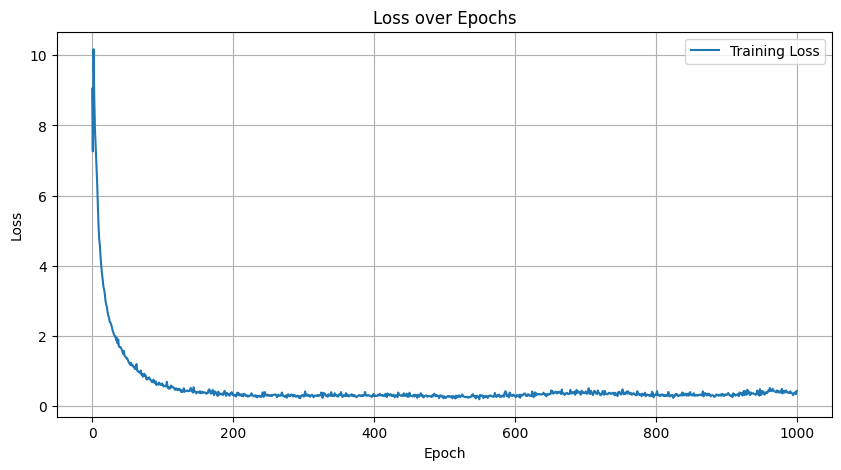

In [6]:
# Задаём гиперпараметры
num_epochs = 1000
learning_rate = 0.1

# Используем модель WordLSTM для работы с последовательностями слов
model = WordLSTM(num_tokens, embedding_dim=128, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    batch_count = 0  # Счетчик количества батчей

    for batch in generate_chunk():
        batch_count += 1
        batch = torch.tensor(batch, dtype=torch.int64).to(device)
        input_seq = batch[:, :-1]
        target_seq = batch[:, 1:]

        optimizer.zero_grad()
        output, _ = model(input_seq)
        output = output.view(-1, num_tokens)
        loss = criterion(output, target_seq.reshape(-1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss / batch_count)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_history[-1]:.4f}")

# Построение графика функции потерь
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Training Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def generate_sample(word_lstm, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    Генерирует текст, используя слова в качестве единиц.
    :param word_lstm: обученная модель LSTM
    :param seed_phrase: строка с начальным фрагментом, который будет продолжен
    :param max_length: максимальная длина сгенерированного текста
    :param temperature: коэффициент температуры для регулирования случайности при сэмплинге
    :param device: устройство для вычислений
    :return: сгенерированный текст (строка), где слова разделены пробелами + запятые
    '''
    if seed_phrase is not None:
        # Разбиваем начальную фразу на слова
        seed_tokens = seed_phrase.split()
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_tokens if token in token_to_idx]
        generated_tokens = seed_tokens[:]  # начинаем с уже заданных слов (без <sos>)
    else:
        x_sequence = [token_to_idx['<sos>']]
        generated_tokens = []

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hidden = None

    for _ in range(max_length - len(generated_tokens)):
        # Прогоняем текущую последовательность через модель
        output, hidden = word_lstm(x_sequence, hidden)
        output = output[:, -1, :]  # Берем только последний выход
        # Применяем температуру и получаем вероятностное распределение
        probabilities = torch.softmax(output / temperature, dim=-1).squeeze().cpu().data.numpy()
        next_token_idx = np.random.choice(len(probabilities), p=probabilities)
        # Если встретили токен <eos>, прекращаем генерацию
        if idx_to_token[next_token_idx] == '<eos>':
            break
        next_word = idx_to_token[next_token_idx]
        generated_tokens.append(next_word)
        # Обновляем вход для следующей итерации (только последний сгенерированный токен)
        x_sequence = torch.tensor([[next_token_idx]], dtype=torch.int64).to(device)

    return " ".join(generated_tokens)

In [8]:
seed_phrase = ' мой дядя самых честных правил'

generated_phrases = [
    generate_sample(
        model,
        seed_phrase,
        max_length=500,
        temperature=0.9  # В зависимости от качества генерации можно подобрать другое значение температуры
    ).replace('<sos>', '')
    for _ in range(3)
]

In [9]:
generated_phrases

['мой дядя самых честных правил ? исчезло счастье юных лет его черты . недели назначен хочу ? скажите : вашею душой какое чувство овладеет без службы , осталась наконец одна . шла одна бы няня знать могла , да недогадлива ты ли , которой он пренебрегал в толпе ревнивых дев , ты посвятил ее вниманье , другой успел ее страданье любовной лестью усыпить , улан умел ее пленить , улан любим ее душою … и скоро стали неразлучны . так люди … хоть это строго ; на цыпочках летит , и голосок ее звучит нежней свирельного напева : как изменилася татьяна ! как твердо в роль свою вошла ! как утеснительного сана приемы скоро приняла ! кто б смел искать девчонки нежной в сей величавой , в сей небрежной законодательнице зал ? и с x , с нею не вела . и были детские проказы ей чужды : страшные рассказы зимою в темноте ночей пленяли больше сердце ей . когда же няня собирала для ольги был , невинной прелести жизни мирной понять , что наши свежие за свои грехи . идет она одна , ее смущение , усталость в его д

# Генерация на уровне символов

In [10]:
# Чтение файла
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.read()

# Приводим текст к нижнему регистру
text = text.lower()

# Создаём алфавит из всех уникальных символов
vocab = sorted(set(text))  # Получаем список уникальных символов
num_tokens = len(vocab)

# Создаем словари для преобразования символов в индексы и обратно
token_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_token = {idx: char for idx, char in enumerate(vocab)}

# Кодируем весь текст в виде индексов
text_encoded = [token_to_idx[char] for char in text]

print(f"Размер словаря (количество уникальных символов): {num_tokens}")
print(f"Количество символов в корпусе: {len(text_encoded)}")

Размер словаря (количество уникальных символов): 84
Количество символов в корпусе: 152374


In [11]:
# Подготовка батчей для обучения

batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx[' ']  # Начальный токен можно выбрать пробелом

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length
    start_index = np.random.randint(0, len(text_encoded) - batch_size * seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size * seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))  # Добавляем стартовую колонку


In [12]:
# Создаем модель LSTM
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(CharLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Векторное представление символов
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)  # Выход - вероятности для каждого символа

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # Преобразуем индексы символов в эмбеддинги
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)  # Прогноз следующего символа
        return output, hidden

Epoch 1/1000, Loss: 4.4437
Epoch 2/1000, Loss: 3.1639
Epoch 3/1000, Loss: 4.6595
Epoch 4/1000, Loss: 3.4201
Epoch 5/1000, Loss: 2.9289
Epoch 6/1000, Loss: 2.8322
Epoch 7/1000, Loss: 2.7008
Epoch 8/1000, Loss: 2.5943
Epoch 9/1000, Loss: 2.5237
Epoch 10/1000, Loss: 2.5057
Epoch 11/1000, Loss: 2.4749
Epoch 12/1000, Loss: 2.3900
Epoch 13/1000, Loss: 2.3852
Epoch 14/1000, Loss: 2.3773
Epoch 15/1000, Loss: 2.3306
Epoch 16/1000, Loss: 2.2999
Epoch 17/1000, Loss: 2.2898
Epoch 18/1000, Loss: 2.2635
Epoch 19/1000, Loss: 2.2418
Epoch 20/1000, Loss: 2.2289
Epoch 21/1000, Loss: 2.2616
Epoch 22/1000, Loss: 2.2142
Epoch 23/1000, Loss: 2.1769
Epoch 24/1000, Loss: 2.1685
Epoch 25/1000, Loss: 2.1574
Epoch 26/1000, Loss: 2.1578
Epoch 27/1000, Loss: 2.2150
Epoch 28/1000, Loss: 2.1826
Epoch 29/1000, Loss: 2.1313
Epoch 30/1000, Loss: 2.0927
Epoch 31/1000, Loss: 2.1732
Epoch 32/1000, Loss: 2.0668
Epoch 33/1000, Loss: 2.0839
Epoch 34/1000, Loss: 2.1425
Epoch 35/1000, Loss: 2.0413
Epoch 36/1000, Loss: 2.0856
E

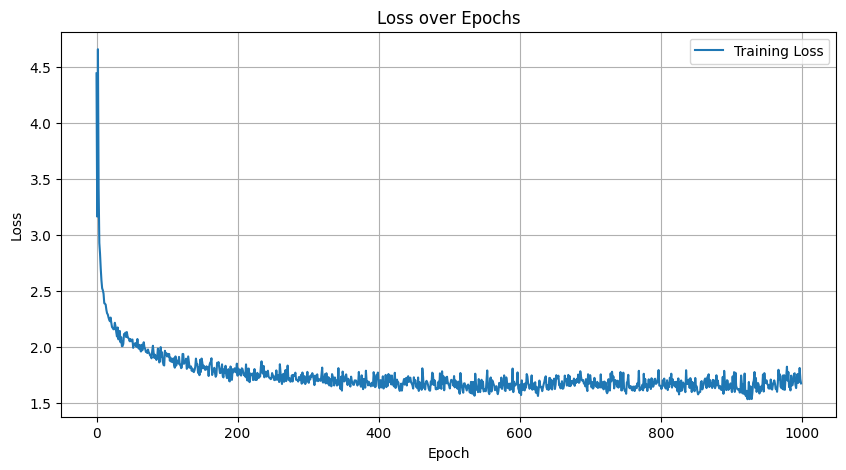

In [13]:
# Задаём гиперпараметры
num_epochs = 1000
learning_rate = 0.1

# Используем модель WordLSTM для работы с последовательностями слов
model = WordLSTM(num_tokens, embedding_dim=128, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    batch_count = 0  # Счетчик количества батчей

    for batch in generate_chunk():
        batch_count += 1
        batch = torch.tensor(batch, dtype=torch.int64).to(device)
        input_seq = batch[:, :-1]
        target_seq = batch[:, 1:]

        optimizer.zero_grad()
        output, _ = model(input_seq)
        output = output.view(-1, num_tokens)
        loss = criterion(output, target_seq.reshape(-1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss / batch_count)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_history[-1]:.4f}")

# Построение графика функции потерь
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Training Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
def generate_sample(model, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    """
    Генерация текста посимвольно.
    """
    if seed_phrase is not None:
        seed_tokens = [token_to_idx[char] for char in seed_phrase if char in token_to_idx]
    else:
        seed_tokens = [token_to_idx[' ']]  # Начинаем с пробела

    x_sequence = torch.tensor([seed_tokens], dtype=torch.int64).to(device)
    hidden = None
    generated_text = seed_phrase if seed_phrase else ""

    for _ in range(max_length - len(generated_text)):
        output, hidden = model(x_sequence, hidden)
        output = output[:, -1, :]  # Берём последний символ
        probabilities = torch.softmax(output / temperature, dim=-1).squeeze().cpu().data.numpy()
        next_token_idx = np.random.choice(len(probabilities), p=probabilities)
        next_char = idx_to_token[next_token_idx]

        generated_text += next_char
        x_sequence = torch.tensor([[next_token_idx]], dtype=torch.int64).to(device)

    return generated_text

In [21]:
seed_phrase = "мой дядя самых честных правил"
generated_text = generate_sample(model, seed_phrase, max_length=5000, temperature=0.5)

In [18]:
generated_text

'мой дядя самых честных правил\n\t\tи душею молодовой надежды;\n\t\tнадумавно ленский\n\t\tонегин жимы порогаровы толпа сталы,\n\t\tодна проверь». – «ковь отла встречают нас не в примета, что отверчиворело годился, за татьяна стетшивает и шкак онегин свои салб\n\t\tа в ней дар,\n\t\tмне модною годов мою;\n\t\tонегина там\n\t\tс как жертв жертва, под саможду после тани об ни ж? хара налень тани москвы, верти мень мало, веканье, слушалы альбом\n\t\tотках,\n\t\tумиль она,\n\t\tперегиною палеком сосед.\n\t\tглавы;\n\t\tзатеснье мой нас.\n\n'

# Анализ результатов

In [19]:
generated_phrases

['мой дядя самых честных правил ? исчезло счастье юных лет его черты . недели назначен хочу ? скажите : вашею душой какое чувство овладеет без службы , осталась наконец одна . шла одна бы няня знать могла , да недогадлива ты ли , которой он пренебрегал в толпе ревнивых дев , ты посвятил ее вниманье , другой успел ее страданье любовной лестью усыпить , улан умел ее пленить , улан любим ее душою … и скоро стали неразлучны . так люди … хоть это строго ; на цыпочках летит , и голосок ее звучит нежней свирельного напева : как изменилася татьяна ! как твердо в роль свою вошла ! как утеснительного сана приемы скоро приняла ! кто б смел искать девчонки нежной в сей величавой , в сей небрежной законодательнице зал ? и с x , с нею не вела . и были детские проказы ей чужды : страшные рассказы зимою в темноте ночей пленяли больше сердце ей . когда же няня собирала для ольги был , невинной прелести жизни мирной понять , что наши свежие за свои грехи . идет она одна , ее смущение , усталость в его д

In [22]:
generated_text

'мой дядя самых честных правил хоть совленье старины;\n\t\tпро старает,\n\t\tи моей, весь нас видал\n\t\tи в свои не своим слез упрямо старины пораженской поэт пора невнесен, она привычка,\n\t\tдоворяст он не таня в темно старины так мой старых так она всё были всех дали\n\t\tпора татьяна собой мечтанье,\n\t\tчто сердца сперечестью старинных,\n\t\tона лиц оставить молодой\n\t\tи в так она, старины, подробнова поэта\n\t\tсемья\n\t\tон еще слушной воздался в мельниц мой вду тесной их дамстворил в ней любился снегов свои после так от мальчиков такой\n\t\tи всё согласенье,\n\t\tкто красавиц подавно он был то всё стам он там на благотно мой привычкая все на своех полней\n\t\tона с ней онегин видела в ставеду невольно мне приставими дам.\n\n\n\nxxiiii\n\n\t\tда мечтой.\n\n\n\nxlii\n\n\t\tи не спорится в том, томной свои мечтанья,\n\t\tда мой меня простом привычка тихо выманый стариный малющей молчны, в подруга\n\t\tпривычкак на счастный поэта,\n\t\tчто не старины;\n\t\tон дамы,\n\t\tкак слад

Визуально субъективно заметно, что текст приятнее при генерации пословно, а не посимвольно.
Почему?
- слова не формируются целиком, это сбивает модель
- длинные зависимости сложнее улавливать
- происходит более весомое накопление ошибок

Также сравнивая графики лосса заметная более выраженная нестабильность при обучении, что также обуслаливает большую неустойчивость при генерации посимвольно.

